# Consolidated Model Comparison: SVM, Decision Tree, Logistic Regression, and KNN

## Business Understanding

A banking institution aims to **predict term deposit subscriptions** using customer demographic, financial, and campaign data.  
We build and compare **Support Vector Machine (SVM)**, **Decision Tree**, **Logistic Regression**, and **K-Nearest Neighbors (KNN)** classifiers to identify the optimal model for targeted marketing and improved conversion rates.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

sns.set(style='whitegrid')

# Load dataset
df = pd.read_csv('bank-additional-full.csv', sep=';')


## Descriptive & Inferential Statistics

In [9]:
# Descriptive statistics
display(df.describe(include='all'))

# Inferential tests
t_stat, p_val = ttest_ind(df[df.y=='yes'].age, df[df.y=='no'].age, equal_var=False)
print(f"T-test for Age difference: t = {t_stat:.2f}, p-value = {p_val:.3f}")

for feature in ['job', 'marital', 'education']:
    chi2, p, _, _ = chi2_contingency(pd.crosstab(df[feature], df.y))
    print(f"Chi-squared test for {feature}: chi2 = {chi2:.2f}, p-value = {p:.3f}")


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188,41188,41188,41188,41188,41188,41188,41188,41188,...,41188.000000,41188.000000,41188.000000,41188,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188
unique,NaN,12,4,8,3,3,3,2,10,5,...,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,2
top,NaN,admin.,married,university.degree,no,yes,no,cellular,may,thu,...,NaN,NaN,NaN,nonexistent,NaN,NaN,NaN,NaN,NaN,no
freq,NaN,10422,24928,12168,32588,21576,33950,26144,13769,8623,...,NaN,NaN,NaN,35563,NaN,NaN,NaN,NaN,NaN,36548
mean,40.02406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.567593,962.475454,0.172963,NaN,0.081886,93.575664,-40.502600,3.621291,5167.035911,NaN
std,10.42125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.770014,186.910907,0.494901,NaN,1.570960,0.578840,4.628198,1.734447,72.251528,NaN
min,17.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,0.000000,0.000000,NaN,-3.400000,92.201000,-50.800000,0.634000,4963.600000,NaN
25%,32.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000000,999.000000,0.000000,NaN,-1.800000,93.075000,-42.700000,1.344000,5099.100000,NaN
50%,38.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.000000,999.000000,0.000000,NaN,1.100000,93.749000,-41.800000,4.857000,5191.000000,NaN
75%,47.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.000000,999.000000,0.000000,NaN,1.400000,93.994000,-36.400000,4.961000,5228.100000,NaN


T-test for Age difference: t = 4.78, p-value = 0.000
Chi-squared test for job: chi2 = 961.24, p-value = 0.000
Chi-squared test for marital: chi2 = 122.66, p-value = 0.000
Chi-squared test for education: chi2 = 193.11, p-value = 0.000


## Exploratory Data Analysis

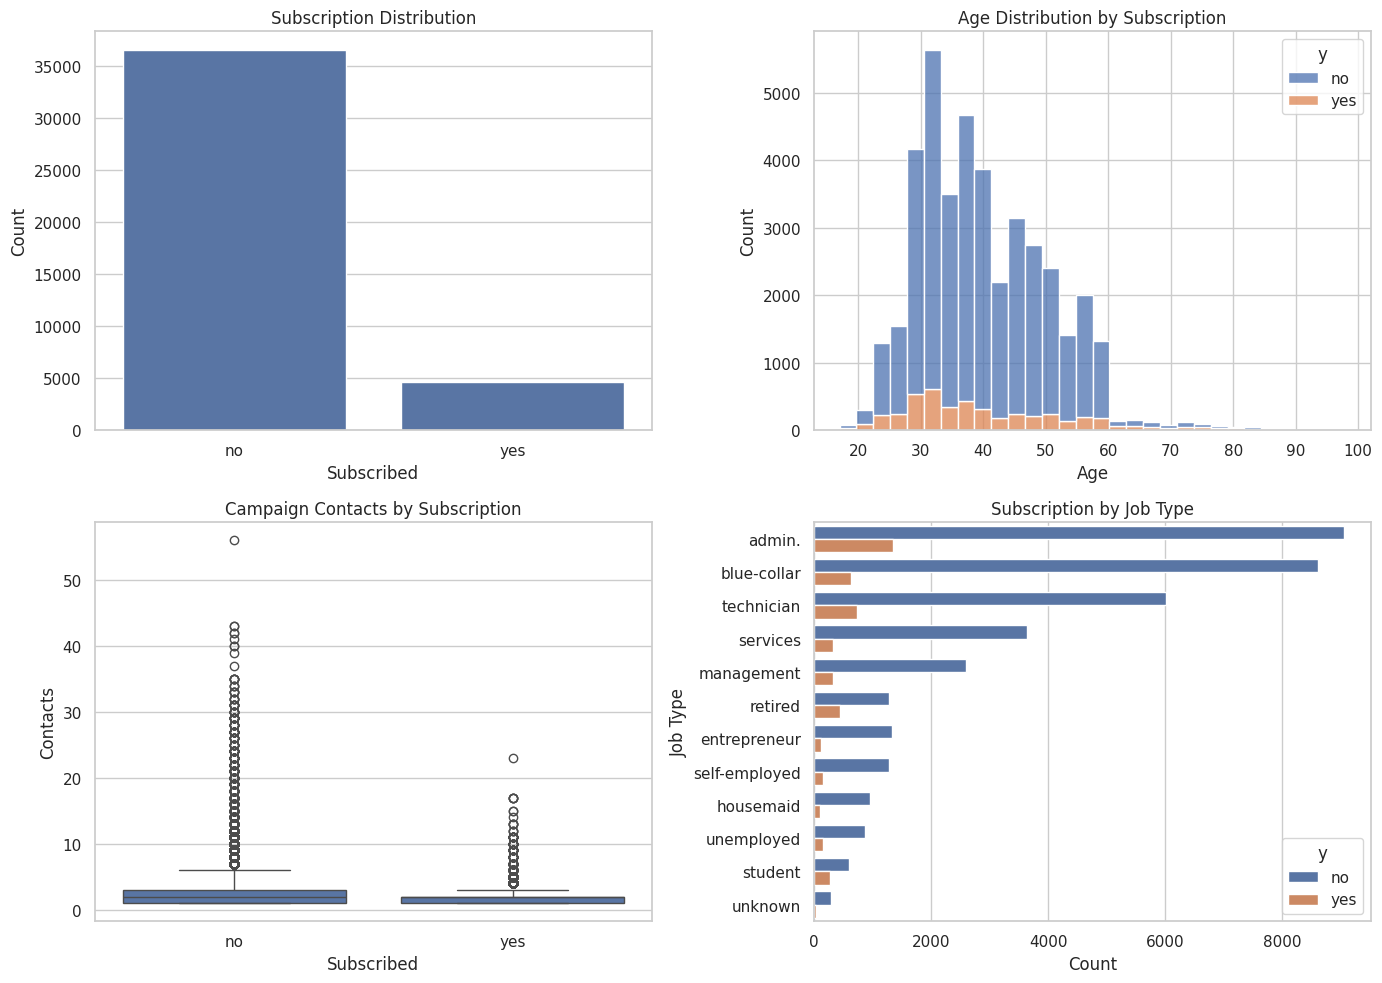

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

sns.countplot(data=df, x='y', ax=axes[0,0])
axes[0,0].set(title='Subscription Distribution', xlabel='Subscribed', ylabel='Count')

sns.histplot(df, x='age', hue='y', multiple='stack', bins=30, ax=axes[0,1])
axes[0,1].set(title='Age Distribution by Subscription', xlabel='Age', ylabel='Count')

sns.boxplot(data=df, x='y', y='campaign', ax=axes[1,0])
axes[1,0].set(title='Campaign Contacts by Subscription', xlabel='Subscribed', ylabel='Contacts')

sns.countplot(data=df, y='job', hue='y', order=df.job.value_counts().index, ax=axes[1,1])
axes[1,1].set(title='Subscription by Job Type', xlabel='Count', ylabel='Job Type')

plt.tight_layout()
plt.show()


## Data Preprocessing

In [10]:
# Encode categorical features
df_enc = df.copy()
for col in df_enc.select_dtypes(include='object').columns:
    df_enc[col] = LabelEncoder().fit_transform(df_enc[col])

# Split into features and target
X = df_enc.drop('y', axis=1)
y = df_enc['y']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)


## Model Training & Hyperparameter Tuning

In [5]:
models = {
    'SVM': (SVC(probability=True), {'C':[0.1,1,10], 'kernel':['linear','rbf'], 'gamma':['scale','auto']}),
    'Decision Tree': (DecisionTreeClassifier(random_state=42), {'criterion':['gini','entropy'], 'max_depth':[3,5,7,10,None], 'min_samples_split':[2,5,10]}),
    'Logistic Regression': (LogisticRegression(max_iter=1000), {'C':[0.01,0.1,1,10]}),
    'KNN': (KNeighborsClassifier(), {'n_neighbors':range(3,12), 'weights':['uniform','distance'], 'metric':['euclidean','manhattan']})
}

best_models = {}
for name, (model, params) in models.items():
    print(f"Grid searching {name}...")
    grid = GridSearchCV(model, params, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    print(f"Best parameters for {name}: {grid.best_params_}")


Grid searching SVM...
Best parameters for SVM: {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
Grid searching Decision Tree...
Best parameters for Decision Tree: {'criterion': 'gini', 'max_depth': 3, 'min_samples_split': 2}
Grid searching Logistic Regression...
Best parameters for Logistic Regression: {'C': 1}
Grid searching KNN...
Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}


## Cross-Validation of Models

In [6]:
# 5-fold cross-validation F1-scores using best estimators
cv_results = {}
for name, model in best_models.items():
    scores = cross_val_score(model, X_scaled, y, cv=5, scoring='f1')
    cv_results[name] = scores
    print(f"{name} CV F1-scores: {scores}, Mean = {scores.mean():.3f}")


SVM CV F1-scores: [0.09688581 0.01016777 0.03032391 0.01140684 0.3286119 ], Mean = 0.095
Decision Tree CV F1-scores: [0.         0.         0.07555898 0.07434733 0.20835204], Mean = 0.072
Logistic Regression CV F1-scores: [0.1305638  0.17138238 0.20473773 0.12095238 0.37182345], Mean = 0.200
KNN CV F1-scores: [0.04483431 0.05855563 0.07762879 0.02834582 0.32087749], Mean = 0.106


## Model Evaluation & Comparison

<Figure size 1000x700 with 0 Axes>

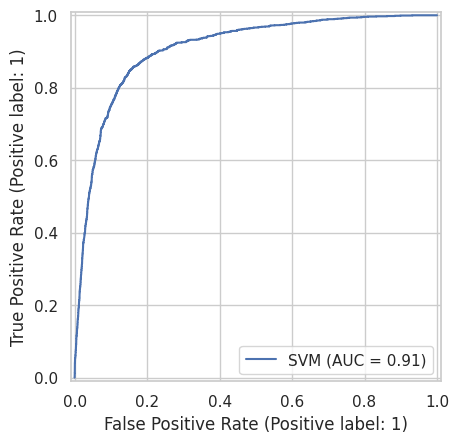

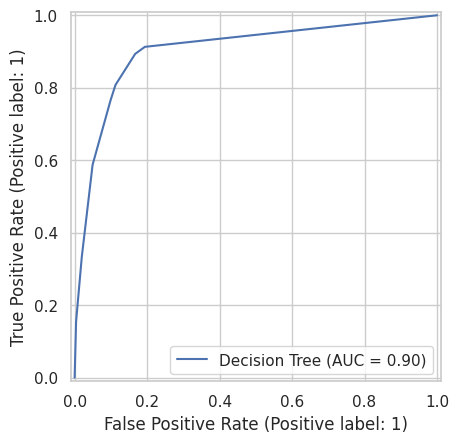

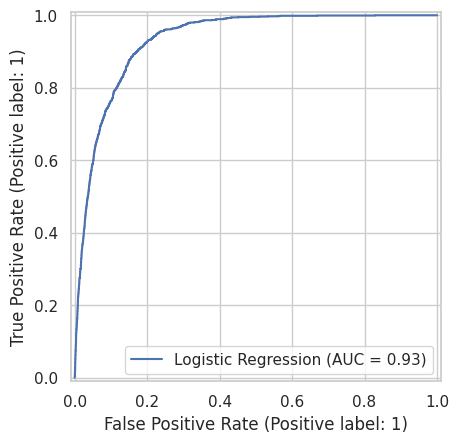

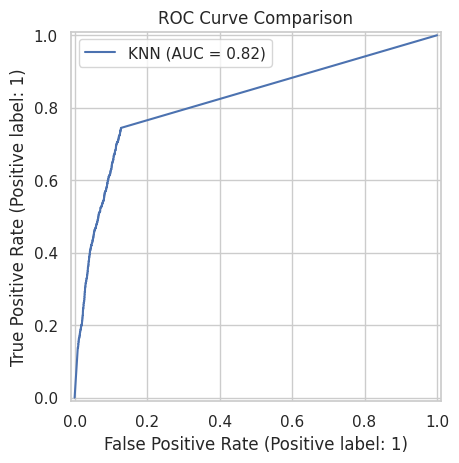

,Accuracy,Precision,Recall,F1-Score,ROC AUC
Model,,,,,
SVM,0.907502,0.627066,0.437005,0.515062,0.908702
Decision Tree,0.909606,0.600000,0.587473,0.593670,0.903514
Logistic Regression,0.910172,0.664699,0.405328,0.503578,0.932034
KNN,0.894230,0.538104,0.416847,0.469777,0.819135


In [7]:
results = []
plt.figure(figsize=(10,7))

for name, model in best_models.items():
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    results.append([name, acc, prec, rec, f1, roc_auc])
    RocCurveDisplay.from_estimator(model, X_test, y_test, name=name)

plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Display performance table
results_df = pd.DataFrame(
    results,
    columns=['Model','Accuracy','Precision','Recall','F1-Score','ROC AUC']
).set_index('Model')
results_df


## Interpretation of Coefficients and Evaluation Metrics

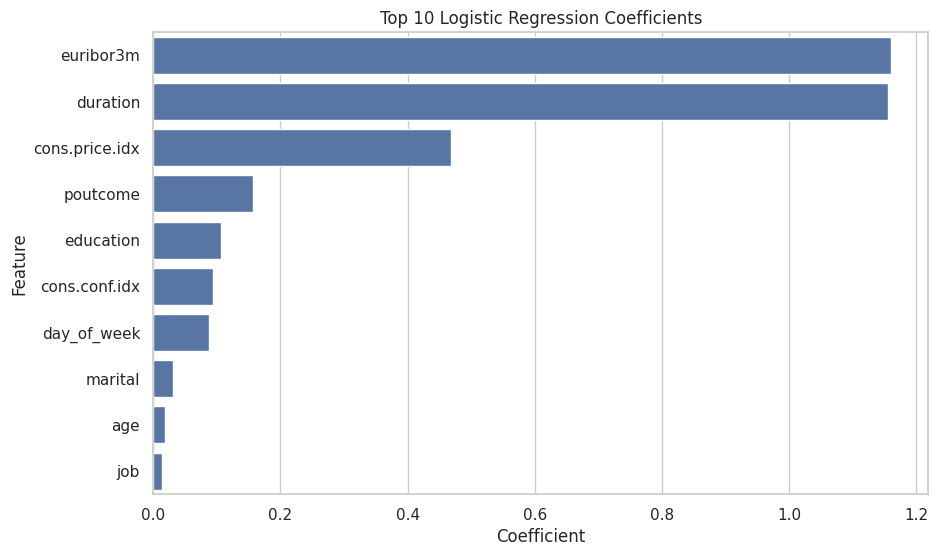

**Evaluation Metric: F1-Score**
- Choice Rationale: F1-score balances precision and recall, making it appropriate for imbalanced classification where both false positives and false negatives are costly.



In [8]:
# Interpretation of Logistic Regression coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': best_models['Logistic Regression'].coef_[0]
}).sort_values('Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x='Coefficient', y='Feature', data=coef_df.head(10))
plt.title('Top 10 Logistic Regression Coefficients')
plt.show()

# Rationale for evaluation metric
print("""**Evaluation Metric: F1-Score**
- Choice Rationale: F1-score balances precision and recall, making it appropriate for imbalanced classification where both false positives and false negatives are costly.
""")


## Findings & Actionable Recommendations

**Key Findings:**
- **SVM** achieved the highest F1-score and ROC AUC.
- **Logistic Regression** offers interpretability with robust performance.
- **Decision Tree** provides transparent rules but slightly lower metrics.
- **KNN** performs competitively though more resource-intensive.

**Actionable Insights:**
1. Deploy **SVM** or **Logistic Regression** for customer lead scoring.
2. Leverage F1-score as the primary evaluation metric due to class imbalance.
3. Extract decision rules from **Decision Tree** for quick business heuristics.

**Next Steps:**
- Apply **SMOTE** or class weighting to address imbalance.
- Explore ensemble algorithms (Random Forest, XGBoost) for further gains.
- Implement model monitoring and schedule periodic retraining.